# $\overline{\underline{\Large{\textrm{Capital Colocado por Entidad Federativa}}}}$

## 0. Consideraciones

Para la elaboracion del mapa se emplearon los archivos *".shp"*  proporcionados por la página web:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ https://shapesdemexico.wixsite.com/shapes/entidades-federativas



además de que se usaron los datos del sigueinte archivo de Google Sheets:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ https://docs.google.com/spreadsheets/d/1HipYUYlIP9UVmRwewpDsdrerJr1cPKX27hge7SECfIk/edit?usp=sharing

## 1. Auntenficiación y Conexión a Google Sheets con Cuenta de Servicio

In [1]:
import json
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Ruta al archivo JSON con credenciales de la cuenta de servicio
json_creds_path = 'D:/Descargas/quiet-axon-428807-i5-7dd33844ea64.json'

# Definir el alcance de la API
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']

# Cargar las credenciales desde el archivo JSON
credentials = ServiceAccountCredentials.from_json_keyfile_name(json_creds_path, scope)

# Autenticar con las credenciales
gc = gspread.authorize(credentials)


## 2. Carga de Datos de una Hoja de Google Sheets

In [2]:
import pandas as pd
from gspread_dataframe import get_as_dataframe

# URL del Google Sheets y nombre de la hoja donde almacenamos los datos
link = "https://docs.google.com/spreadsheets/d/1HipYUYlIP9UVmRwewpDsdrerJr1cPKX27hge7SECfIk/edit?usp=sharing"
sheet_name = "Data Mapa"


# Abrir la hoja de Google Sheets
sh = gc.open_by_url(link)

# Seleccionar la hoja específica
worksheet = sh.worksheet(sheet_name)

# Obtener todos los valores de la hoja
data = worksheet.get_all_values()

# Crear un DataFrame con los datos
Valores_México = pd.DataFrame(data[1:], columns=data[0])

## 3. Limpieza y Formateo de Datos

In [3]:
# Seleccionar las columnas relevantes
df = Valores_México[['ESTADO2', 'CAPITAL','ESTADO']].copy()

# Convertir la columna 'CAPITAL' a numérico, eliminando comas y símbolos de moneda
df['CAPITAL'] = pd.to_numeric(df['CAPITAL'].str.replace(',', '').str.replace('\$', '', regex=True))

# Redondear la columna 'CAPITAL' a un decimal
df['CAPITAL'] = df['CAPITAL'].round(1)


## 4. Importación y Carga de Siluetas de México

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

mexico = gpd.read_file(r'D:\Descargas\Entidades_Federativas\Entidades_Federativas.shp')

# Combinar los datos con el shapefile
mexico_2 = mexico.merge(df, how='left', left_on='NOMGEO', right_on='ESTADO2')

## 5. Creación del Mapa de Calor

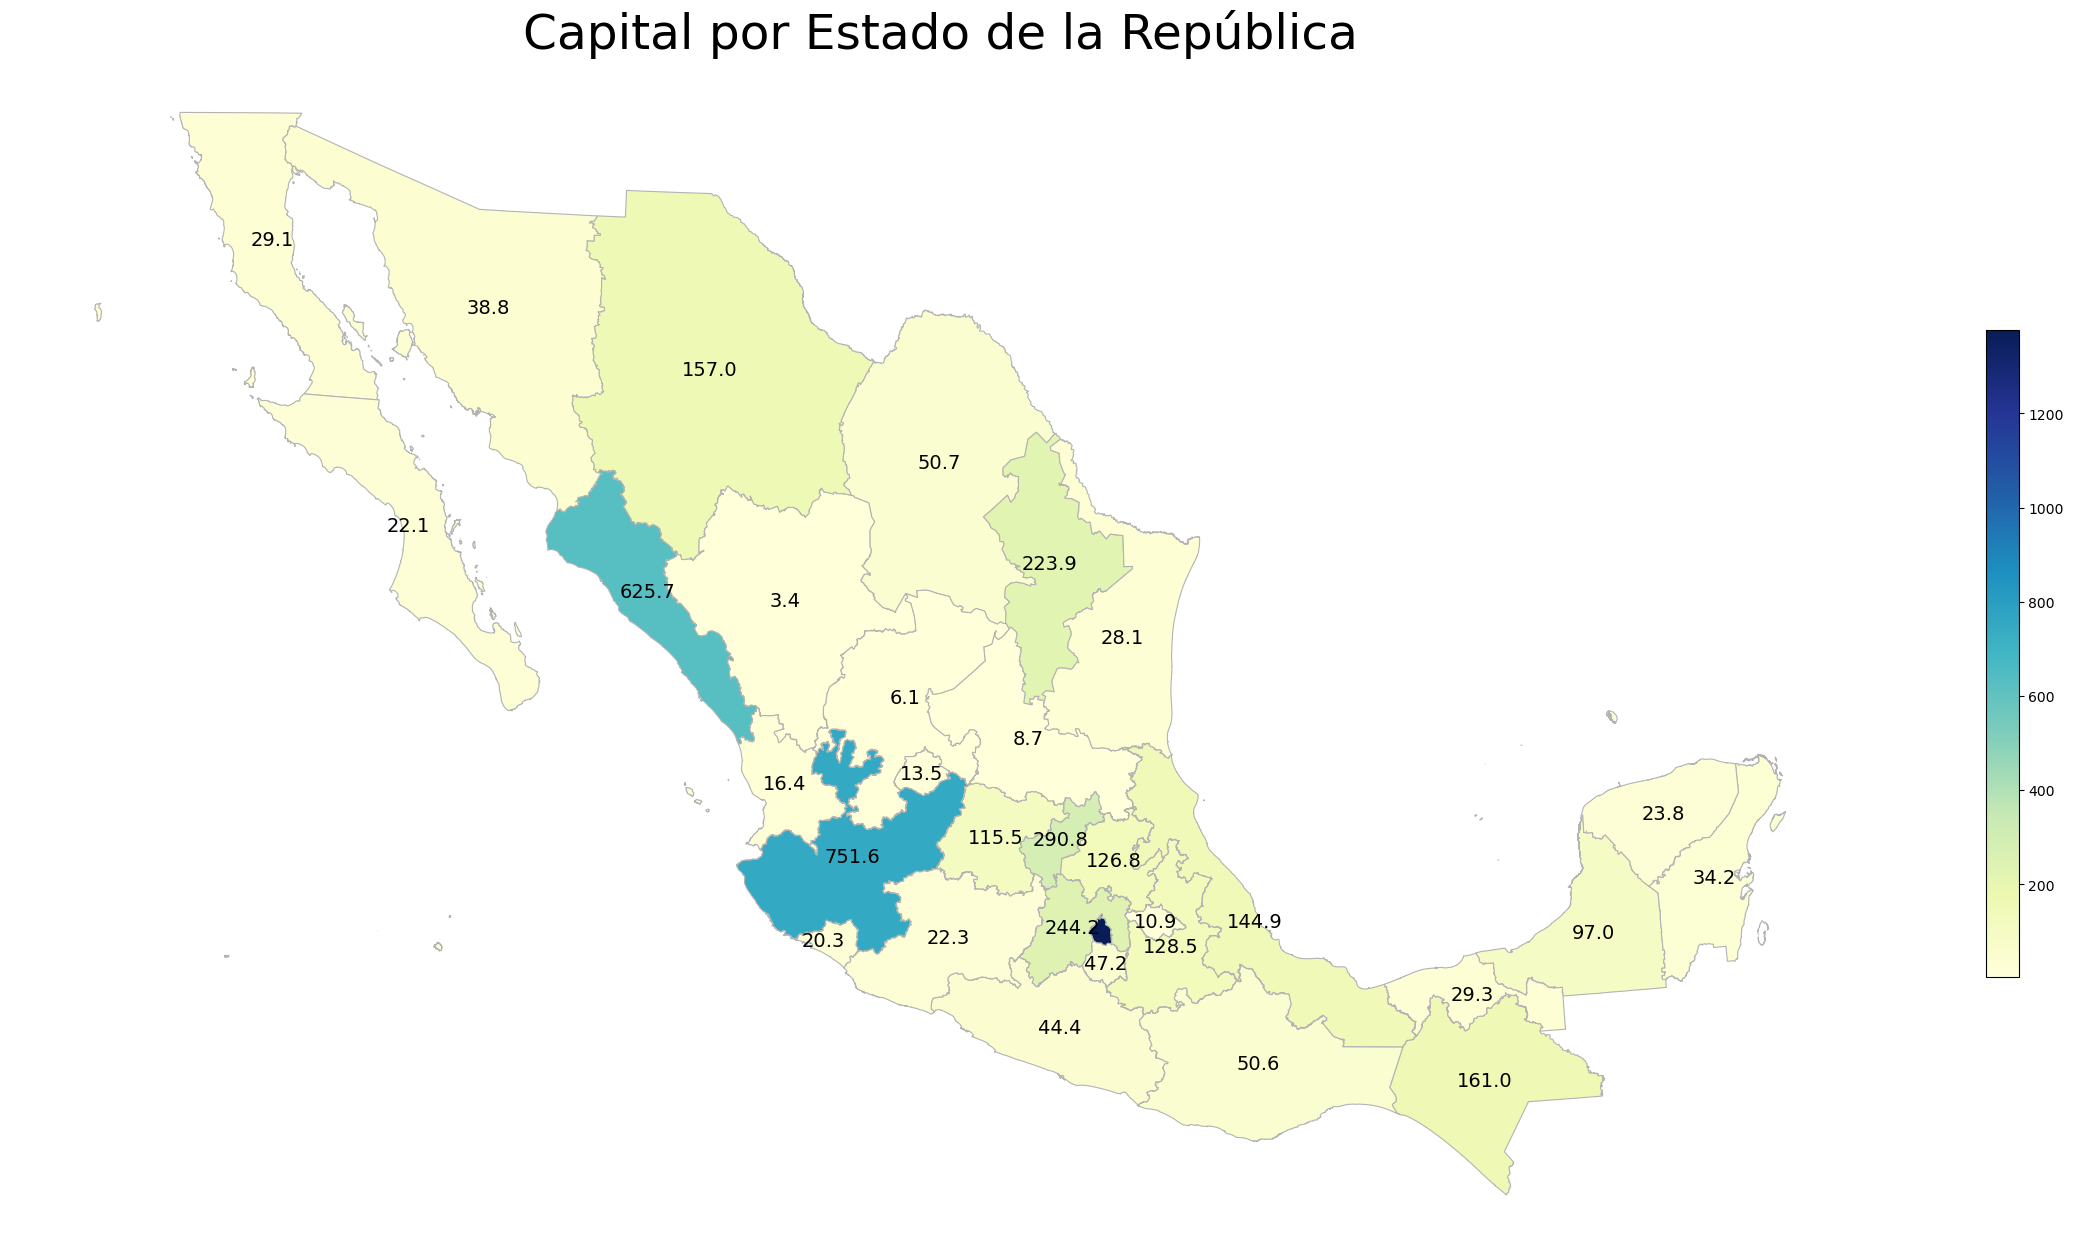

In [5]:
# Ordenar el DataFrame por la columna 'CAPITAL' en orden descendente y seleccionar los cinco primeros registros
# Se ordena el DataFrame 'mexico_2' basado en la columna 'CAPITAL' en orden descendente y se seleccionan los registros del 2° al 6°.
capitales = mexico_2.sort_values(by='CAPITAL', ascending=False).iloc[1:]

# Crear el mapa de calor
# Se crea una figura y un eje para la visualización del mapa de calor de tamaño 30x24 pulgadas.
fig, ax = plt.subplots(1, 1, figsize=(30, 24))

# Se plotea el mapa de calor de México usando la columna 'CAPITAL' para la intensidad del color.
# Se usa la paleta de colores 'YlGnBu', con un grosor de línea de 0.8 y un borde gris.
# Se añade una leyenda con un tamaño reducido.
mexico_2.plot(column='CAPITAL', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.7', legend=True, legend_kwds={'shrink': 0.35})

# Agregar etiquetas a los cinco estados con los valores más altos
# Para los cinco estados con los valores más altos de 'CAPITAL', se añaden etiquetas centradas en cada estado.
for x, y, label in zip(capitales.geometry.centroid.x, capitales.geometry.centroid.y, capitales['CAPITAL']):
    ax.text(x, y, label, fontsize=14, ha='center', va='center', color='black')

# Se ocultan los ejes del gráfico.
ax.axis('off')

# Se establece el título del mapa.
ax.set_title('Capital por Estado de la República', fontdict={'fontsize': '35', 'fontweight': '5'})

# Se muestra el mapa de calor.
plt.show()
